# Cifar10 Pipeline

## Prequisites

#### Following dependent packages needs to be installed before running the build script

1. kfp - `! pip install git+https://github.com/kubeflow/pipelines.git#subdirectory=sdk/python`
2. docker - should be logged in using docker login
3. yq - install using snap - https://github.com/mikefarah/yq
4. jq - v1.6 - https://stedolan.github.io/jq/download/

#### ./build.sh takes two arguments

1. path to example - For ex: examples/cifar10
2. dockerhub username - For ex: shrinathsuresh


In [1]:
import kfp


## Install packages

In [1]:
!pip install captum torchvision matplotlib pillow flask flask_compress

**Make sure the current working directory is "pytorch_pipeline"**

In [62]:
import os
os.getcwd()

'/home/arvind/Documents/Facebook/Facebook_Eng2/pytorch-pipeline/pytorch_pipeline'

## Generate Pipeline file

In [72]:
!./build.sh examples/cifar10 arvindideas2it

++++ Building component images with tag=18-05-2021-20-19-07.216013
IMAGE TO BUILD: arvindideas2it/pytorch_pipeline:18-05-2021-20-19-07.216013
Sending build context to Docker daemon  106.2MB
Step 1/9 : FROM pytorch/pytorch:latest
 ---> 5ffed6c83695
Step 2/9 : COPY requirements.txt requirements.txt
 ---> Using cache
 ---> 4a5fb6a738ea
Step 3/9 : RUN apt-get update
 ---> Using cache
 ---> 05c14456b115
Step 4/9 : RUN apt-get install -y git
 ---> Using cache
 ---> dd1252b2f453
Step 5/9 : RUN git clone -b fix/runpipeline_notebook https://github.com/jagadeeshi2i/pytorch-pipeline
 ---> Using cache
 ---> 8e539d710cb2
Step 6/9 : RUN pip3 install -r requirements.txt
 ---> Using cache
 ---> 1ddf3a36e2e5
Step 7/9 : ENV PYTHONPATH /workspace/pytorch-pipeline
 ---> Using cache
 ---> 3c9e5a7409bb
Step 8/9 : WORKDIR /workspace/pytorch-pipeline
 ---> Using cache
 ---> e210d248b0c5
Step 9/9 : ENTRYPOINT /bin/bash
 ---> Using cache
 ---> 13a985004812
Successfully built 13a985004812
Successfully tagged arv

## At the end of this step - pytorch_cifar10.yaml file will be generated

In [73]:
import kfp
import json
import os
from PIL import Image
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url
from kfp import dsl
from kfp import compiler
from pathlib import Path

kfp.__version__

'1.6.0-rc.0'

# Enter your KFP URL and the token from the cookie
[Use this extension on chrome to get token]( https://chrome.google.com/webstore/detail/editthiscookie/fngmhnnpilhplaeedifhccceomclgfbg?hl=en)
![image.png](image.png)

## Set Pipeline URL, Cookie, Experiment and Namespac

In [74]:
# KFP_URL='istio-ingressgateway.istio-system.svc.cluster.local'
KFP_URL='http://localhost:8080'
COOKIE="MTYyMTMxOTA4OXxOd3dBTkZSVE0xRkNRVmxGTlZnMlRGWk5OMDQzUlVzMlNWQktORk16V1RKRVFrUlNSa2MzUzBkYVJrRTBVRWxYVGs1VVNFaGFRbEU9fHNj2aSBzbE3gGKUVXSzVAVawKPw9pY4wd2QOVpsKfuo"
AUTH="authservice_session="+COOKIE
NAMESPACE="kubeflow-user-example-com"
EXPERIMENT="Default"

## Set Log bucket and Tensorboard Image

In [75]:
MINIO_ENDPOINT="http://minio-service.kubeflow:9000"
LOG_BUCKET="mlpipeline"
TENSORBOARD_IMAGE="jagadeeshj/tb_plugin:v1.8"

## Set Inference parameters

In [76]:
MODEL_NAME="cifar10"
DEPLOY_NAME="torchserve"
ISVC_NAME=DEPLOY_NAME+"."+NAMESPACE+"."+"example.com"
INFERENCE_URL="http://istio-ingressgateway.istio-system.svc.cluster.local"
INPUT_REQUEST="https://kubeflow-dataset.s3.us-east-2.amazonaws.com/cifar10_input/input.json"

## Create KFP Client and create an experiment

In [78]:
client = kfp.Client(host=KFP_URL+"/pipeline", cookies=AUTH)
client.create_experiment(name=EXPERIMENT, namespace=NAMESPACE)
experiments = client.list_experiments(namespace=NAMESPACE)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 4, 22, 8, 44, 39, tzinfo=tzutc()),
 'description': None,
 'id': 'aac96a63-616e-4d88-9334-6ca8df2bb956',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'kubeflow-user-example-com',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

## Pipeline params

In [71]:
pipeline_params = {
    "minio_endpoint" : MINIO_ENDPOINT,
    "tf_image" : TENSORBOARD_IMAGE,
    "log_bucket" : LOG_BUCKET,
    "input_req" : INPUT_REQUEST,
    "cookie" :  COOKIE,
    "ingress_gateway" : INFERENCE_URL,
    "isvc_name" : ISVC_NAME,
    "deploy" : DEPLOY_NAME,
    "model" : MODEL_NAME,
    "namespace" : NAMESPACE,
}

## Click on Run Details for navigating to pipeline

In [70]:
run_name = 'pytorch-cifar10'
# Execute pipeline
run = client.run_pipeline(my_experiment.id, run_name, "pytorch_cifar10.yaml", pipeline_params)

## Get Inference service name

In [22]:
INFERENCE_SERVICE_LIST = ! kubectl get isvc $DEPLOY_NAME -n kubeflow-user-example-com -o json | jq .status.url | tr -d '"'| cut -d "/" -f 3
INFERENCE_SERVICE_NAME = INFERENCE_SERVICE_LIST[0]
INFERENCE_SERVICE_NAME

'torchserve.kubeflow-user-example-com.example.com'

In [23]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:predict" -d @./examples/cifar10/input.json > cifar10_prediction_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:8080...
* Connected to localhost (127.0.0.1) port 8080 (#0)
> POST /v1/models/cifar10:predict HTTP/1.1
> Host: torchserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.71.1
> Accept: */*
> Cookie: authservice_session=MTYyMTMxOTA4OXxOd3dBTkZSVE0xRkNRVmxGTlZnMlRGWk5OMDQzUlVzMlNWQktORk16V1RKRVFrUlNSa2MzUzBkYVJrRTBVRWxYVGs1VVNFaGFRbEU9fHNj2aSBzbE3gGKUVXSzVAVawKPw9pY4wd2QOVpsKfuo
> Content-Length: 148025
> Content-Type: application/x-www-form-urlencoded
> 
} [65536 bytes data]
* We are completely uploaded and fine
100  144k    0     0  100  144k      0  46185  0:00:03  0:00:03 --:--:-- 46185* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< content-length: 149
< content-type: application/json; charset=UTF-8
< date: 

In [24]:
! cat cifar10_prediction_output.json

{"predictions": [{"9": 0.2949771583080292, "6": 0.24301643669605255, "1": 0.22052912414073944, "0": 0.18786683678627014, "8": 0.026764443144202232}]}

In [25]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:explain" -d @./examples/cifar10/input.json > cifar10_explanation_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:8080...
* Connected to localhost (127.0.0.1) port 8080 (#0)
> POST /v1/models/cifar10:explain HTTP/1.1
> Host: torchserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.71.1
> Accept: */*
> Cookie: authservice_session=MTYyMTMxOTA4OXxOd3dBTkZSVE0xRkNRVmxGTlZnMlRGWk5OMDQzUlVzMlNWQktORk16V1RKRVFrUlNSa2MzUzBkYVJrRTBVRWxYVGs1VVNFaGFRbEU9fHNj2aSBzbE3gGKUVXSzVAVawKPw9pY4wd2QOVpsKfuo
> Content-Length: 148025
> Content-Type: application/x-www-form-urlencoded
> 
} [65536 bytes data]
* We are completely uploaded and fine
100  144k    0     0  100  144k      0   3344  0:00:44  0:00:44 --:--:--     0* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< content-length: 3462376
< content-type: application/json; charset=UTF-8
< da

In [64]:
! head -5 cifar10_explanation_output.json

{"explanations": [[[[2.8941023365101333e-05, 0.004612406746162236, 0.015941165981277487, -0.003348937615001273, 0.002401917452102551, -0.016738701804394535, -0.03708172372202822, -0.01781041651115429, -0.01215098650025865, -0.003234655419110495, -0.018661387790926805, 0.010457203474097098, -0.010443934479322032, -0.009857281133438723, 0.0004075965929658714, 0.007669164377119367, -0.004699702553000703, -0.005876744837673486, 0.03489785541889425, 0.009914736387072987, -0.03127048336861889, -0.014643606381095605, -0.013856009883750416, 0.004887810090928961, -0.017170027852158005, -0.03302331196944705, -0.012607321569422573, 0.016582908497888366, 0.004728176858883909, -0.00893525711122199, -0.044963119286293395, -0.052421525269188, -0.009049279262928322, 0.04264393758044392, 0.019294197663413837, -0.0072324581281511145, -0.032972172614991094, -0.00567683225145326, -0.012920491709878336, -0.012464292411822673, -0.008073116994442301, 0.0011638711171575115, 0.0027490425662141326, 0.0023478968

59529080532e-05, -2.3019205911593038e-05, -0.0010707472548014488, -0.0003410142676231172, -0.004499282200757265, -0.00248681715510642, 0.0003200500460571891, 1.8852161787096092e-05, -0.0017343954844567999, -0.0002536214636425509, 3.953051915699566e-05, 0.00015253726991192572, -0.0007579482582627106, -0.0013872002522704674, -4.700538539943373e-05, 0.00014949063803528471, -0.0021758900728453736, 0.00034768516295170397, 0.0009856633040988148, 0.00015670663180682336, 8.2723873474218e-06, 0.0001446766702453898, 0.0007558735335211713, 0.0002230577777958461, -0.0006936879002465302, -2.4228066616833505e-05, 0.00012941928991809761, 1.0577828781077907e-05, 8.018156407238506e-06, -0.00018403367036877837, -0.00017898573163629787, -9.840444724869541e-05, 0.00015508623009647757, 0.0003782581819354052, -6.732622975385305e-06, 0.0011326602307441536, 0.00033203657720709393, 0.000696690820223146, -9.33057261736098e-06, 3.4552754197942655e-05, 0.0003910266751142867, 0.0008712839282035214, 0.0015342362449

932, -0.00027717758585841596, -0.00010023443615799692, 0.00046056302701563776, 0.0001814513949723024, -0.0005449688664236973, -0.001611764176700453, 0.00011609314148024214, 9.813606373850419e-05, 0.000609250389305828, 0.0023654541412426577, 0.004033710864605721, 0.0011852563016924618, -0.0008332997758376091, -0.0003974791751891719, -2.329111109990437e-06, 0.0007722735105930901, 0.0014235648922794634, -0.000743506572619208, -0.0008462803061953068, 0.0005511954764443771, 0.00031188236497488385, -0.00032068180107488163, 0.00038340564462848944], [0.027599608822611022, 0.010559779798099383, 0.009251109262749965, 0.01768041994466375, 0.002813421977304402, -0.002706899073808482, -0.01203129342417897, -0.0036281927523513897, -0.01653937197269475, -0.0008569043382392002, 0.008114396000322318, -0.02042227509412228, -0.0014596845247531914, 0.0010601846194247795, 0.011523143762892847, -0.02429637786083075, 0.006048426395001042, 0.006167178428963949, -0.010913413215007443, 0.009585015422795724, -0.

08501426224, 0.0017451116203492237, 0.0024694965899347216, 0.0028832036443138874, 0.00274826922359853, 0.0006501728861777584, 0.0007305151025711768, 0.0010358066852607778, 0.000490806577017757, -0.00013204462583179987, -0.0014123304029262825, 0.0037168446585586798, 0.003430628850266696, -0.0006591232380439979, 0.00026388052962619075, 5.377983600014668e-05, 0.0009089540932635763, 0.0007379470938685925, 0.00048425695786396346, 0.0006148271920084996, -0.00010349183100358233, 0.001022005236197399, -0.0005964874271984615, 5.630683876841531e-05, -0.003431402966961819, 0.0002505015121497238, -0.001630588285981676, 0.0019449390588214717, 0.0029914044496466606, -0.002613572422406345, 0.0011485719431855964, 0.0020218845093146697, 0.0006859166588166286, 0.0005008512406641506, -0.0002644735266291547, 0.0004908008568449961, 0.0008986516108676959, -0.0006406221067039145, -0.0007180515058544096, 0.00015104480790984024, -0.0001426339519245807, 0.0012716802573550408, 0.0021249741694074425, 0.0014598985

 0.012484624479305937, 0.009585136768500488, -0.007965716826646114, -0.00018988157191527933, 0.0011803061412826766, -0.011728663346994768, -0.00569359932906049, 0.00373060405346258, 0.004094888851135719, -0.002215155831077591, -0.0011689437805995706, -0.010008295023117729, -0.0023701593403197643, 0.010010903132463061, -0.007501678144374248, -0.0006314534252088302, 0.0036723226119057015, -0.007941306653060268, -0.001486441060309443, 0.0017242296735895375, 0.0003911476673544631, 0.00031809977657434814, 0.00044386653268027804, -0.001058918007885494, -0.001403788779402277, 0.00019448190389118465, 5.444707836880924e-05, 7.046804152360128e-05, 0.0001424169546404039, 1.1087871320473493e-05, 0.00023831451608722834, 0.00017332262005115317, -0.0005727544507768725, -0.0005215487421525739, 0.0001741325766310913, -0.0002904385271077177, -0.0009588004070125656, -0.000527579311528823, 0.00013765533264749279, -0.0006440626221324549, -0.0020445812577970348, -0.0006122612963841463, -0.000366674605666588

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [48]:
import json
import numpy as np 
explainations_json = json.loads(open("./cifar10_explanation_output.json", "r").read())
attributions = explainations_json['explanations']
attributions = np.array(attributions)
attributions = attributions.reshape((224,224,3))
attributions.shape, type(attributions)

((224, 224, 3), numpy.ndarray)

In [28]:
prediction_json = json.loads(open("./cifar10_prediction_output.json", "r").read())
prediction_json["predictions"][0]


{'9': 0.2949771583080292,
 '6': 0.24301643669605255,
 '1': 0.22052912414073944,
 '0': 0.18786683678627014,
 '8': 0.026764443144202232}

In [52]:
import json
import os
import logging
import numpy as np


from PIL import Image
import torchvision.transforms as transforms


from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F

import captum
from captum.attr import NoiseTunnel
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

from examples.cifar10.cifar10_train  import CIFAR10Classifier

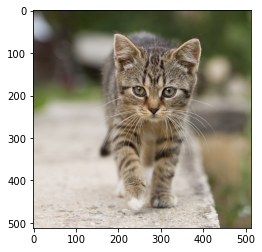

In [30]:
#Read the test image
test_img = Image.open('./examples/cifar10/kitten.png')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()
# img = Image.open("examples/cifar10/kitten.png")

In [31]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [33]:
labels_path = './examples/cifar10/class_mapping.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data) 
list(map(lambda k: idx_to_labels[k], idx_to_labels.keys()))

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [153]:
import os
from minio import Minio
import urllib3
minio_config = {
            "HOST": "http://localhost:9000",
            "ACCESS_KEY": "minio",
            "SECRET_KEY": "minio123",
            "BUCKET": "mlpipeline",
            "FOLDER": " mar/4da2ad03-bf93-4206-8806-2589feee87f9/model-store"}

def _initiate_minio_client(minio_config):
        minio_host = minio_config["HOST"]
        access_key = minio_config["ACCESS_KEY"]
        secret_key = minio_config["SECRET_KEY"]
        client = Minio(minio_host, access_key=access_key, secret_key=secret_key, secure=False)
        return client




In [159]:
minio_config = {
            "HOST": "localhost:9000",
            "ACCESS_KEY": "minio",
            "SECRET_KEY": "minio123",
            "BUCKET": "mlpipeline",
            "FOLDER": " s3:/mlpipeline/modelfile-store/e3311d39-9bb1-43a6-bf6b-c78951dc3dfd"}

def _initiate_minio_client(minio_config):
        minio_host = minio_config["HOST"]
        access_key = minio_config["ACCESS_KEY"]
        secret_key = minio_config["SECRET_KEY"]
        client = Minio(minio_host, access_key=access_key, secret_key=secret_key, secure=False)
        return client





client= _initiate_minio_client(minio_config)
client

In [161]:
def download_artifact_to_minio(folder: str, artifact: str):
        artifact_name = artifact.split("/")[-1]
        result = client.fget_object(
            minio_config["BUCKET"],
            os.path.join(folder, artifact_name),
            artifact,
        )
        print(result)      


In [163]:
download_artifact_to_minio("s3:/mlpipeline/modelfile-store/e3311d39-9bb1-43a6-bf6b-c78951dc3dfd","resnet.pth")

In [165]:
model = CIFAR10Classifier()
model_pt_path ="./resnet.pth"
model.load_state_dict(torch.load(model_pt_path,map_location=torch.device('cpu')))
model.eval()

CIFAR10Classifier(
  (model_conv): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

#### Captum Vis and Insights

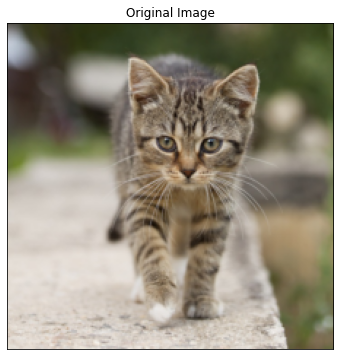

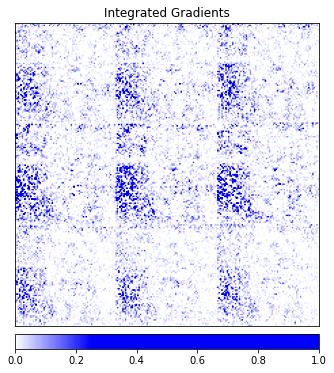

In [49]:
# Show the original image for comparison
#np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(attributions,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In [54]:
imgs = ['./examples/cifar10/kitten.png',"./examples/cifar10/horse.png"]

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: cat / 3  ( 0.18024620413780212 )
Predicted: horse / 7  ( 0.15090999007225037 )


In [57]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[3,7])]
)

In [58]:
visualizer.render(debug =True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

In [169]:
visualizer.serve(debug=True)


Fetch data and view Captum Insights at http://localhost:38601/



38601

## Clean up
### Delete Viewers, Inference Services and Completed pods

In [167]:
! kubectl delete --all viewers -n $NAMESPACE

viewer.kubeflow.org "viewer-0a2171acce1d3ab74dcc22cc0f6e3b1b5b868916" deleted
viewer.kubeflow.org "viewer-2387e6cf111cbda7117831c1b49eca96b0aecdcf" deleted
viewer.kubeflow.org "viewer-2a62fd9b2208a0cb082124c0632525aa68e90494" deleted
viewer.kubeflow.org "viewer-2c39735d6b46d6ecb06524bb1b09e61213e19747" deleted
viewer.kubeflow.org "viewer-5d9d86c4bcfc77b31f5363d84c2ef05f8f0a97fd" deleted
viewer.kubeflow.org "viewer-62908d72b0084dee176271bfb395105a7fc1219b" deleted
viewer.kubeflow.org "viewer-76ef7e33e224e6f5b579c5d0361627c51109acec" deleted
viewer.kubeflow.org "viewer-a5e7fce5ad270e16df9a15fd7a1ddd1c2738b5d5" deleted
viewer.kubeflow.org "viewer-c5523e8aeb58c801f1b64a702367658debe6d402" deleted
viewer.kubeflow.org "viewer-c6ec6526eaf0244a536116dc6d7db62d1e9ac021" deleted
viewer.kubeflow.org "viewer-f55024e87d5d56e541b30712cb9e690dc9609b6f" deleted


In [168]:
! kubectl delete --all isvc -n $NAMESPACE

inferenceservice.serving.kubeflow.org "bertserve" deleted
inferenceservice.serving.kubeflow.org "mnist-ax" deleted
inferenceservice.serving.kubeflow.org "torchserve" deleted


In [ ]:
! kubectl delete pod --field-selector=status.phase==Succeeded -n $NAMESPACE